# Data Visualization with Matplotlib
- Visualizing the Difference in Differences between stations inside zones and before/after the congestion pricing zone. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("manhattan_subways.csv", parse_dates=["transit_date"])

# Create treatment and post indicators
df['treated'] = df['inside_zone']
df['post'] = df['in_2025']

# Create relative week from treatment (Jan 1, 2025)
treat_date = pd.to_datetime("2025-01-01")
df['weeks_from_treat'] = ((df['transit_date'] - treat_date).dt.days // 7).astype(int)


In [2]:
# Group by week and treated/control
grouped = df.groupby(['weeks_from_treat', 'treated']).agg(
    mean_riders=('station_ridership', 'mean'),
    se=('station_ridership', lambda x: x.std(ddof=1) / (x.count() ** 0.5))
).reset_index()

# Create upper/lower bounds for CI
grouped['ci_upper'] = grouped['mean_riders'] + 1.96 * grouped['se']
grouped['ci_lower'] = grouped['mean_riders'] - 1.96 * grouped['se']


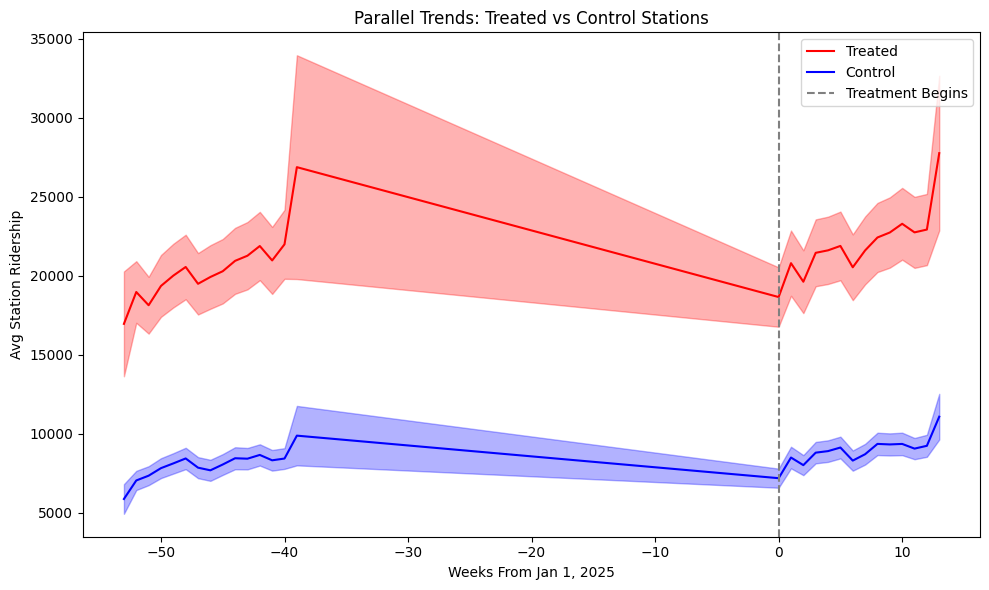

In [3]:
plt.figure(figsize=(10, 6))

for treated_val, label, color in zip([1, 0], ["Treated", "Control"], ["red", "blue"]):
    sub = grouped[grouped['treated'] == treated_val]
    plt.plot(sub['weeks_from_treat'], sub['mean_riders'], label=label, color=color)
    plt.fill_between(sub['weeks_from_treat'], sub['ci_lower'], sub['ci_upper'], 
                     alpha=0.3, color=color)

plt.axvline(x=0, linestyle='--', color='gray', label='Treatment Begins')
plt.xlabel("Weeks From Jan 1, 2025")
plt.ylabel("Avg Station Ridership")
plt.title("Parallel Trends: Treated vs Control Stations")
plt.legend()
plt.tight_layout()
plt.show()
